In [1]:
%load_ext autoreload
%autoreload 2

In [236]:
from math import log
import numpy as np
from analysis.ngram import calculate_avg_ll
from analysis.plot_utils import plt, legend_opts, savefig
from matplotlib.animation import FuncAnimation

In [3]:
def calculate_avg_ln(prob_matrix, weights=None):
    return calculate_avg_ll(prob_matrix, weights, log_function=np.log)

## Combine models sequentially

In [4]:
train_prob_matrix = np.load('../data/train_prob_matrix.npy')
dev1_prob_matrix = np.load('../data/dev1_prob_matrix.npy')
dev2_prob_matrix = np.load('../data/dev2_prob_matrix.npy')

In [5]:
dev_prob_matrix = np.vstack([dev1_prob_matrix, dev2_prob_matrix])
dev_prob_matrix.shape

(803176, 6)

In [6]:
train_avg_lls = []
dev1_avg_lls = []
dev2_avg_lls = []
dev_avg_lls = []
labels = []
label = ''

ngram_combo = []
for n in range(6):
    ngram_combo.append(n)
    train_avg_lls.append(calculate_avg_ln(train_prob_matrix[:, ngram_combo]))
    dev1_avg_lls.append(calculate_avg_ln(dev1_prob_matrix[:, ngram_combo]))
    dev2_avg_lls.append(calculate_avg_ln(dev2_prob_matrix[:, ngram_combo]))
    dev_avg_lls.append(calculate_avg_ln(dev_prob_matrix[:, ngram_combo]))
    
    label += f'{n}\n'
    labels.append(label)
labels[0] = '0\n(uniform)'

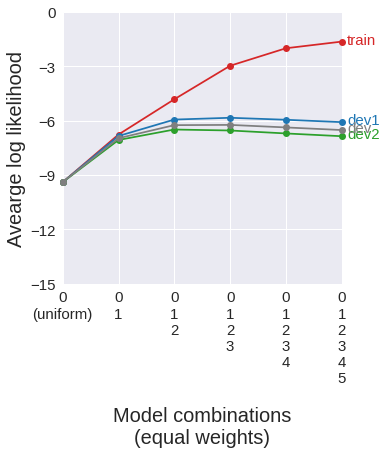

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(ngram_combo, train_avg_lls, '-o', color='tab:red', clip_on=False)
ax.plot(ngram_combo, dev1_avg_lls, '-o', color='tab:blue', clip_on=False)
ax.plot(ngram_combo, dev2_avg_lls, '-o', color='tab:green', clip_on=False)
ax.plot(ngram_combo, dev_avg_lls, '-o', color='tab:gray', clip_on=False)

ax.text(5.1, train_avg_lls[-1]+0.1, s='train', va='center', color='tab:red', fontsize=15)
ax.text(5.1, dev1_avg_lls[-1]+0.1, s='dev1', va='center', color='tab:blue', fontsize=15)
ax.text(5.1, dev2_avg_lls[-1]+0.1, s='dev2', va='center', color='tab:green', fontsize=15)
ax.text(5.1, dev_avg_lls[-1]+0.1, s='dev', va='center', color='tab:gray', fontsize=15)

ax.set_xticklabels(labels)
ax.set_xlabel('Model combinations\n(equal weights)')
ax.set_ylabel('Avearge log likelihood')
ax.set_xlim(0, 5)
ax.set_ylim(-15, 0)
ax.set_yticks(range(-15, 1, 3))
plt.show()

savefig(fig, 'what_to_combine.png')

## Interpolating 2 models

In [8]:
unigram_weights = np.linspace(0.0001, 1-0.0001, 100)
dev1_avg_lls = []
dev2_avg_lls = []
dev_avg_lls = []

for unigram_weight in unigram_weights:
    dev1_avg_lls.append(calculate_avg_ln(dev1_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight]))
    dev2_avg_lls.append(calculate_avg_ln(dev2_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight]))
    dev_avg_lls.append(calculate_avg_ln(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight]))

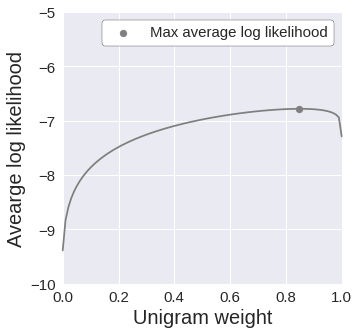

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))

# ax.plot(unigram_weights, dev1_avg_lls, color='tab:blue', clip_on=False)
# ax.plot(unigram_weights, dev2_avg_lls, color='tab:green', clip_on=False)
ax.plot(unigram_weights, dev_avg_lls, color='tab:gray', clip_on=False)

# ax.scatter(unigram_weights[np.argmax(dev1_avg_lls)], np.max(dev1_avg_lls), color='tab:blue', clip_on=False)
# ax.scatter(unigram_weights[np.argmax(dev2_avg_lls)], np.max(dev2_avg_lls), color='tab:green', clip_on=False)
ax.scatter(unigram_weights[np.argmax(dev_avg_lls)], np.max(dev_avg_lls), color='tab:gray', clip_on=False, label='Max average log likelihood')

ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)
ax.legend(**legend_opts)
ax.set_xlabel('Unigram weight')
ax.set_ylabel('Avearge log likelihood')

savefig(fig, 'avg_ll_two_models.png')

## Gradient descent

Stand-alone function

In [10]:
def gradient_descent(prob_matrix, learning_rate, n_iter):
    # 1. Initialize all models to have the same weights
    n_models = prob_matrix.shape[1]
    weights = np.ones(n_models) / n_models
    
    ngram_probs = prob_matrix[:, 1:]
    uniform_prob = prob_matrix[:, [0]]

    for iteration in range(n_iter):
        # 2. Calculate gradients for each n-gram model
        interpolated_probs = np.sum(prob_matrix * weights, axis=1, keepdims=True)
        ngram_gradients = np.mean((ngram_probs - uniform_prob) / interpolated_probs, axis=0)
        
        # 3. Update interpolation weights for all models
        weights[1:] += learning_rate * ngram_gradients
        weights[0] = 1 - sum(weights[1:])
        
    return weights

Class to store intermediate values (for animation)

In [11]:
class GradientDescent:
    def __init__(self, track_iteration=True):
        self.track_iteration = track_iteration
        
    def fit(self, prob_matrix, learning_rate, n_iter=100):
        if self.track_iteration:
            self.tracked_info = {}
            
        n_models = prob_matrix.shape[1]
        self.weights = np.ones(n_models) / n_models

        uniform_prob = prob_matrix[:, [0]]
        ngram_probs = prob_matrix[:, 1:]
        for iteration in range(n_iter):
            interpolated_probs = np.sum(prob_matrix * self.weights, axis=1, keepdims=True)
            gradients = np.mean((ngram_probs - uniform_prob) / interpolated_probs, axis=0)
            if self.track_iteration:
                self.tracked_info[iteration] = {'weights': self.weights.copy(),
                                                'gradients': gradients,
                                                'avg_ll': calculate_avg_ln(prob_matrix, self.weights)}
            self.weights[1:] += learning_rate * gradients
            self.weights[0] = 1 - self.weights[1:].sum()

In [211]:
n_iter = 10
gd = GradientDescent()
gd.fit(dev_prob_matrix[:, :2], learning_rate=0.1, n_iter=n_iter)
gd.weights

array([0.15087213, 0.84912787])

In [13]:
def update(fig, ax, iteration):
    fig.suptitle(f'Iteration {iteration}', fontsize=20)
    ax.lines = [ax.lines[0]]
    ax.collections = [ax.collections[0]]
        
    tangent_length = 0.15
    
    info = gd.tracked_info[iteration]
    unigram_weight = info['weights'][1]
    unigram_gradient = info['gradients'][0]
    avg_ll = info['avg_ll']
    lower_unigram_weight, upper_unigram_weight = unigram_weight - tangent_length, unigram_weight + tangent_length
    lower_ll, upper_ll = avg_ll - unigram_gradient * tangent_length, avg_ll + unigram_gradient * tangent_length
    ax.plot([lower_unigram_weight, upper_unigram_weight], [lower_ll, upper_ll], color='tab:orange')
    ax.vlines(unigram_weight, -10, avg_ll, colors='tab:orange', linestyles='dashed', linewidth=0.5)
    ax.scatter(unigram_weight, avg_ll, color='tab:orange')

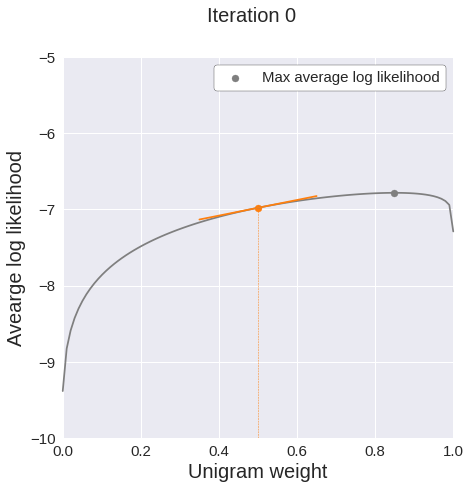

In [87]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(unigram_weights, dev_avg_lls, color='tab:gray', clip_on=False)
ax.scatter(unigram_weights[np.argmax(dev_avg_lls)], np.max(dev_avg_lls), color='tab:gray', clip_on=False, label='Max average log likelihood')
ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)

ax.legend(**legend_opts)
ax.set_xlabel('Unigram weight')
ax.set_ylabel('Avearge log likelihood')

anim = FuncAnimation(fig, lambda iteration: update(fig, ax, iteration), 
                     frames=range(n_iter), interval=300, repeat=True)
anim.save('../viz/gradient_descent.mp4', writer='ffmpeg')

## Expectation-maximation algorithm

### High-level explanation

Two-model example (uniform + unigram)

In [17]:
def calculate_posterior_weights(prob_matrix, unigram_step_weight):
    """Calculate posterior weights for a unigram weight at the current iteration"""
    joint_probs = prob_matrix * [1 - unigram_step_weight, unigram_step_weight]
    marginal_probs = np.sum(joint_probs, axis=1, keepdims=True)
    posterior_weights = joint_probs / marginal_probs
    return posterior_weights

In [18]:
def calculate_lower_bound_ln(prob_matrix, unigram_weight, unigram_step_weight):
    """Calculate lower bound value to each unigram weight
    (parametized by posterior weights corresponding to unigram weight at current iteration).
    This is used to plot the lower bound by inputting an array of unigram weights."""
    true_weights = [1 - unigram_weight, unigram_weight]
    posterior_weights = calculate_posterior_weights(prob_matrix, unigram_step_weight)
    with np.errstate(invalid='ignore'):
        lower_bound_components = posterior_weights * np.log(prob_matrix * true_weights / posterior_weights)
        lower_bound_components[np.isnan(lower_bound_components)] = 0
        lower_bound_ll = np.sum(lower_bound_components, axis=1)
        lower_bound_avg_ll = lower_bound_ll.mean()
    return lower_bound_avg_ll

Step 1: Initialize starting weights

In [175]:
dev_avg_lls = []
dev_lower_bound_avg_lls = []

unigram_weight0 = 0.1
avg_ll0 = calculate_avg_ln(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight0, unigram_weight0])

unigram_weights = np.linspace(0.0001, 1-0.0001, 100)
objective_function = [calculate_avg_ln(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight]) for unigram_weight in unigram_weights]
argmax_objective_function, max_objective_function = unigram_weights[np.argmax(objective_function)], np.max(objective_function)

In [176]:
iter_colors = plt.cm.viridis_r(np.linspace(0.2, 1, 5))

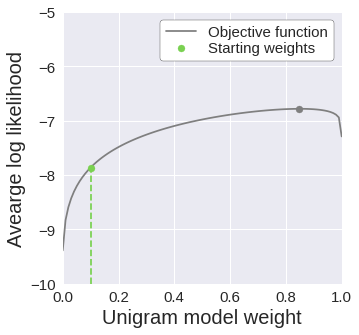

In [177]:
fig, ax = plt.subplots(figsize=(5, 5))

# Plot objective function
ax.plot(unigram_weights, objective_function, color='tab:gray', label='Objective function')
ax.scatter(argmax_objective_function, max_objective_function, color='tab:gray')

# Plot starting weights
ax.scatter(unigram_weight0, avg_ll0,
           color=iter_colors[0], label='Starting weights', zorder=10)
ax.vlines(unigram_weight0, -10, avg_ll0, color=iter_colors[0], linestyles='dashed')
ax.legend(**legend_opts)

ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)
ax.set_xlabel('Unigram model weight')
ax.set_ylabel('Avearge log likelihood')
savefig(fig, 'e1.png')

Step 2: Construct lower bound to objective function that is tight at starting weights (E-step)

In [178]:
lower_bound0 = [calculate_lower_bound_ln(dev_prob_matrix[:, [0, 1]], unigram_weight, unigram_weight0) for unigram_weight in unigram_weights]

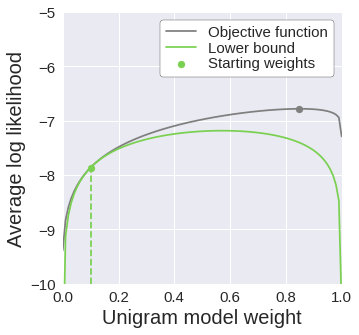

In [319]:
fig, ax = plt.subplots(figsize=(5, 5))

# Plot objective function
ax.plot(unigram_weights, objective_function, color='tab:gray', label='Objective function')
ax.scatter(argmax_objective_function, max_objective_function, color='tab:gray')

# Plot starting weights
ax.scatter(unigram_weight0, avg_ll0,
           color=iter_colors[0], label='Starting weights', zorder=10)
ax.vlines(unigram_weight0, -10, avg_ll0, color=iter_colors[0], linestyles='dashed')

# Plot lower bound
ax.plot(unigram_weights, lower_bound0, color=iter_colors[0], label='Lower bound')
ax.legend(**legend_opts)

ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)
ax.set_xlabel('Unigram model weight')
savefig(fig, 'e2.png')

**Step 3**: Find weights that maximize lower bound from step 2 and update weights to these values

In [220]:
unigram_weight1, lower_bound1 = unigram_weights[np.argmax(lower_bound0)], np.max(lower_bound0)

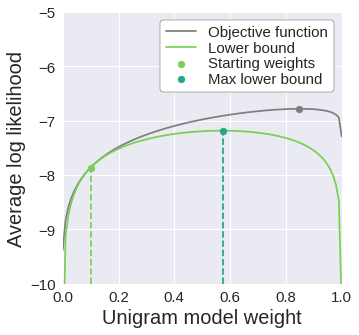

In [320]:
fig, ax = plt.subplots(figsize=(5, 5))

# Plot objective function
ax.plot(unigram_weights, objective_function, color='tab:gray', label='Objective function')
ax.scatter(argmax_objective_function, max_objective_function, color='tab:gray')

# Plot starting weights
ax.scatter(unigram_weight0, avg_ll0,
           color=iter_colors[0], label='Starting weights', zorder=10)
ax.vlines(unigram_weight0, -10, avg_ll0, iter_colors[0], linestyles='dashed')

# Plot lower bound
ax.plot(unigram_weights, lower_bound0, color=iter_colors[0], label='Lower bound')

# Plot max lower bound
ax.scatter(unigram_weight1, lower_bound1,
           color=iter_colors[1], label='Max lower bound', zorder=10)
ax.vlines(unigram_weight1, -10, lower_bound1, color=iter_colors[1], linestyles='dashed')

ax.legend(**legend_opts)

ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)
ax.set_xlabel('Unigram model weight')
savefig(fig, 'e3.png')

**Step 4**: Repeat step 2 and 3

In [322]:
lower_bound1 = [calculate_lower_bound_ln(dev_prob_matrix[:, [0, 1]], unigram_weight, unigram_weight1) for unigram_weight in unigram_weights]
avg_ll1 = calculate_avg_ln(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight1, unigram_weight1])
unigram_weight2, lower_bound2 = unigram_weights[np.argmax(lower_bound1)], np.max(lower_bound1)

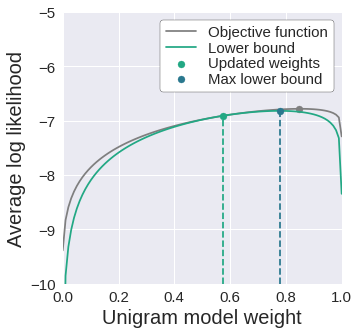

In [323]:
fig, ax = plt.subplots(figsize=(5, 5))

# Plot objective function
ax.plot(unigram_weights, objective_function, color='tab:gray', label='Objective function')
ax.scatter(argmax_objective_function, max_objective_function, color='tab:gray')

# Plot updated weights
ax.scatter(unigram_weight1, avg_ll1,
           color=iter_colors[1], label='Updated weights', zorder=10)
ax.vlines(argmax_lower_bound0, -10, avg_ll1, color=iter_colors[1], linestyles='dashed')

# Plot lower bound
ax.plot(unigram_weights, lower_bound1, color=iter_colors[1], label='Lower bound')

# Plot (new) max lower bound
ax.scatter(unigram_weight2, lower_bound2,
           color=iter_colors[2], label='Max lower bound', zorder=10)
ax.vlines(unigram_weight2, -10, lower_bound2, color=iter_colors[2], linestyles='dashed')

ax.legend(**legend_opts)

ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)
ax.set_xlabel('Unigram model weight')
ax.set_ylabel('Average log likelihood')
savefig(fig, 'repeat.png')

In [325]:
iter_colors[1] * 255

array([ 34.34646 , 167.95218 , 132.000495, 255.      ])

### Why does the lower bound need to be tight?

Tight lower bound

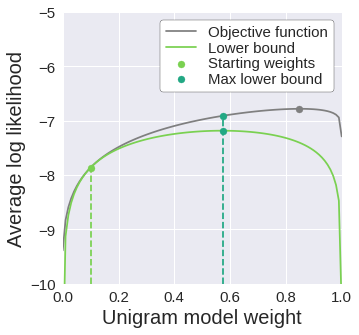

In [223]:
fig, ax = plt.subplots(figsize=(5, 5))

# Plot objective function
ax.plot(unigram_weights, objective_function, color='tab:gray', label='Objective function')
ax.scatter(argmax_objective_function, max_objective_function, color='tab:gray')

# Plot starting weight
ax.scatter(unigram_weight0, avg_ll0,
           color=iter_colors[0], label='Starting weights', zorder=10)
ax.vlines(unigram_weight0, -10, avg_ll0, iter_colors[0], linestyles='dashed')

# Plot lower bound
ax.plot(unigram_weights, lower_bound0, color=iter_colors[0], label='Lower bound')

# Plot max lower bound
ax.scatter(unigram_weight1, lower_bound1,
           color=iter_colors[1], label='Max lower bound', zorder=10)
ax.vlines(unigram_weight1, -10, avg_ll1, color=iter_colors[1], linestyles='dashed')

# Plot average log likelihood of max lower bound
ax.scatter(unigram_weight1, avg_ll1, color=iter_colors[1], zorder=10)

ax.legend(**legend_opts, loc='upper right')

ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)
ax.set_xlabel('Unigram model weight')
ax.set_ylabel('Average log likelihood')
savefig(fig, 'tight_lower_bound.png')

Lose lower bound

In [225]:
unigram_weight_loose = 0.9999
avg_ll_loose = calculate_avg_ln(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight_loose, unigram_weight_loose])

# Create tight lower bound at 0.9, then flip it horizontally and shift down to create loose lowerbound
lower_bound_loose = [calculate_lower_bound_ln(dev_prob_matrix[:, [0, 1]], unigram_weight, unigram_weight_loose) for unigram_weight in unigram_weights]
lower_bound_loose = np.array(lower_bound_loose[::-1]) - 2
lower_bound_loose0 = calculate_lower_bound_ln(dev_prob_matrix[:, [0, 1]], 1-unigram_weight0, unigram_weight_loose) - 2

unigram_weight_loose1, lower_bound_loose1 = unigram_weights[np.argmax(lower_bound_loose)], np.max(lower_bound_loose)
avg_ll_loose1 = calculate_avg_ln(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight_loose1, unigram_weight_loose1])

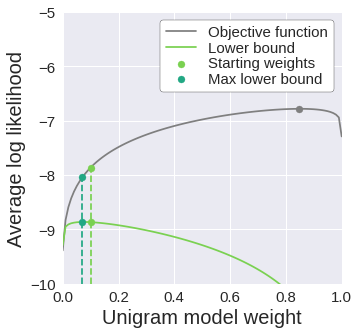

In [326]:
fig, ax = plt.subplots(figsize=(5, 5))

# Plot objective function
ax.plot(unigram_weights, objective_function, color='tab:gray', label='Objective function')
ax.scatter(argmax_objective_function, max_objective_function, color='tab:gray')

# Plot starting weights
ax.scatter(unigram_weight0, avg_ll0,
           color=iter_colors[0], label='Starting weights', zorder=10)
ax.vlines(unigram_weight0, -10, avg_ll0, color=iter_colors[0], linestyles='dashed')

# Plot loose lower bound
ax.plot(unigram_weights, lower_bound_loose, color=iter_colors[0], label='Lower bound')

# Plot average log likelihood of starting weight at loose lower bound
ax.scatter(unigram_weight0, lower_bound_loose0, color=iter_colors[0])

# Plot max lower bound
ax.scatter(unigram_weight_loose1, lower_bound_loose1, color=iter_colors[1], label='Max lower bound', zorder=10)
ax.vlines(argmax_lower_bound_loose0, -10, avg_ll_loose1, color=iter_colors[1], linestyles='dashed')

# Plot average log likelihood of max lower bound
ax.scatter(unigram_weight_loose1, avg_ll_loose1, color=iter_colors[1], zorder=10)

ax.legend(**legend_opts, loc='upper right')

ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)
ax.set_xlabel('Unigram model weight')
ax.set_ylabel('Average log likelihood')
savefig(fig, 'loose_lower_bound.png')

### Jensen's inequality

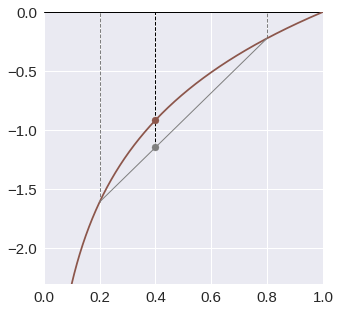

In [272]:
xs = np.linspace(0.1, 1, 1000)
ys = np.log(xs)

fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(0, color='black', lw=1)
ax.set_xlim(0, 1)
ax.set_ylim(log(0.1), 0)

def get_secant_value(x, x_start, x_end):
    return log(x_start) + (log(x_end) - log(x_start)) * (x - x_start) / (x_end - x_start)
# Log
ax.plot(xs, ys, zorder=11, color='tab:brown')

# Secant line
ax.plot([0.2, 0.8], [log(0.2), log(0.8)], color='tab:gray', lw=1, zorder=11)

# 
ax.scatter(0.4, log(0.4), zorder=12, color='tab:brown')
secant_at_04 = get_secant_value(0.4, x_start=0.2, x_end=0.8)
ax.scatter(0.4, secant_at_04, color='tab:gray', zorder=12)
ax.vlines(0.2, log(0.2), 0, color='tab:gray', lw=1, ls='--', zorder=10)
ax.vlines(0.8, log(0.8), 0, color='tab:gray', lw=1, ls='--', zorder=10)
ax.vlines(0.4, secant_at_04, 0, color='black', lw=1, ls='--', zorder=10)

savefig(fig, 'log_jensen.png')

### Lower bound as expectation

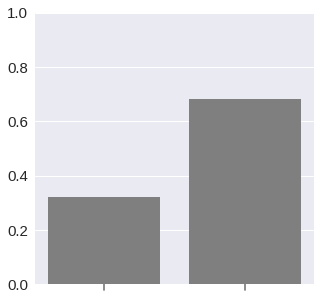

In [318]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.bar([0, 1], [0.32, 0.68], color='tab:gray')
ax.set_xticks([])

ax.set_ylim(0, 1)

ax.axvline(0, -0.02, 0, clip_on=False, color='tab:gray')
ax.axvline(1, -0.02, 0, clip_on=False, color='tab:gray')

savefig(fig, 'z_dist.png')

### Code EM algorithm

In [27]:
def get_em_weights(prob_matrix, n_iter=50):
    n_models = prob_matrix.shape[1]
    weights = np.ones(n_models) / n_models

    for i in range(n_iter):
        weighted_probs = prob_matrix * weights
        total_probs = weighted_probs.sum(axis=1, keepdims=True)

        # E-step
        posterior_probs = weighted_probs / total_probs

        # M-step
        weights = posterior_probs.mean(axis=0)
    return weights

In [48]:
dev_weights = get_em_weights(dev_prob_matrix[:, [0, 1]], n_iter=5)
dev_weights

array([0.15033216, 0.84966784])

Average log likelihood vs lower bound of average likelihood for all words in combined `dev` set

In [30]:
def calculate_posterior_weights(prob_matrix, unigram_step_weight):
    joint_probs = prob_matrix * [1 - unigram_step_weight, unigram_step_weight]
    marginal_probs = np.sum(joint_probs, axis=1, keepdims=True)
    posterior_weights = joint_probs / marginal_probs
    return posterior_weights

In [31]:
def calculate_lower_bound_avg_ll(prob_matrix, true_weights, posterior_weights):
    with np.errstate(invalid='ignore'):
        lower_bound_components = posterior_weights * np.log(prob_matrix * true_weights / posterior_weights)
        lower_bound_components[np.isnan(lower_bound_components)] = 0
        lower_bound_ll = np.sum(lower_bound_components, axis=1)
        lower_bound_avg_ll = lower_bound_ll.mean()
    return lower_bound_avg_ll

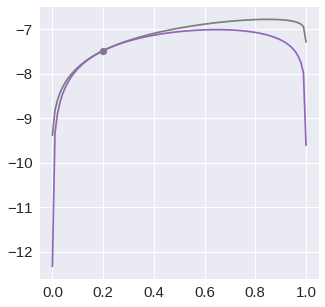

In [32]:
dev_avg_lls = []
dev_lower_bound_avg_lls = []

unigram_step_weight = 0.2
unigram_weights = np.linspace(0.0001, 1-0.0001, 100)
posterior_weights = calculate_posterior_weights(dev_prob_matrix[:, [0, 1]], unigram_step_weight)

for unigram_weight in unigram_weights:
    dev_avg_ll = calculate_avg_ln(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight])
    dev_avg_lls.append(dev_avg_ll)
    
    dev_lower_bound_avg_ll = calculate_lower_bound_avg_ll(dev_prob_matrix[:, [0, 1]],
                                                         true_weights=[1-unigram_weight, unigram_weight],
                                                         posterior_weights=posterior_weights)
    dev_lower_bound_avg_lls.append(dev_lower_bound_avg_ll)
    
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(unigram_weights, dev_avg_lls, color='tab:gray', clip_on=False)
ax.plot(unigram_weights, dev_lower_bound_avg_lls, color='tab:purple', clip_on=False)
ax.scatter(unigram_step_weight, calculate_avg_ln(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_step_weight, unigram_step_weight]), color='tab:gray', clip_on=False)

### EM algorithm

In [33]:
dev_weights = get_em_weights(dev_prob_matrix[:, [0, 1]])

In [34]:
dev_weights

array([0.14949361, 0.85050639])